In [1]:
%load_ext autoreload
%autoreload 2
import comethylation, get_data, analysis, utils

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [196]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

## Read in data

In [116]:
# set args
illum_cpg_locs_fn = "/cellar/users/zkoch/methyl_mut_proj/data/illumina_cpg_450k_locations.csv"
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_072422"
data_dirs = glob.glob( os.path.join("/cellar/users/zkoch/methyl_mut_proj/data", "tcga*data"))

In [117]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, run_name, dataset_names_list = get_data.main(illum_cpg_locs_fn, out_dir, data_dirs)

Getting methylation for lungadeno
Getting methylation for headneck
Getting methylation for stomach
Getting methylation for lungsquam
Getting methylation for melanoma
Getting methylation for colonrectal
Getting methylation for uteran
Getting methylation for bladder
Getting methylation for esophageal
Getting methylation for breast
Getting methylation for prostate
Getting methylation for glioblastomamulti
Getting methylation for cervical
Getting methylation for pancreatic
Getting methylation for lowergradeglioma


## Do mutation analyses

/cellar/users/zkoch/methylation_and_mutation/analysis.py:73: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write("Effect size: {}\n".format( ct_mutation_in_measured_cpg_df.mean()))
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


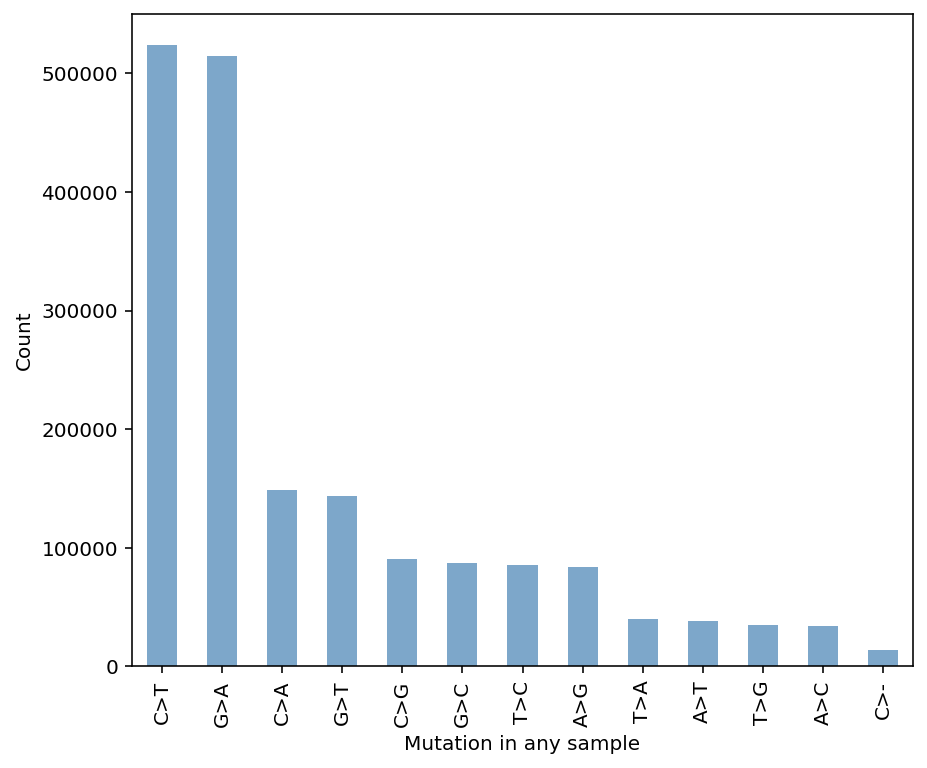

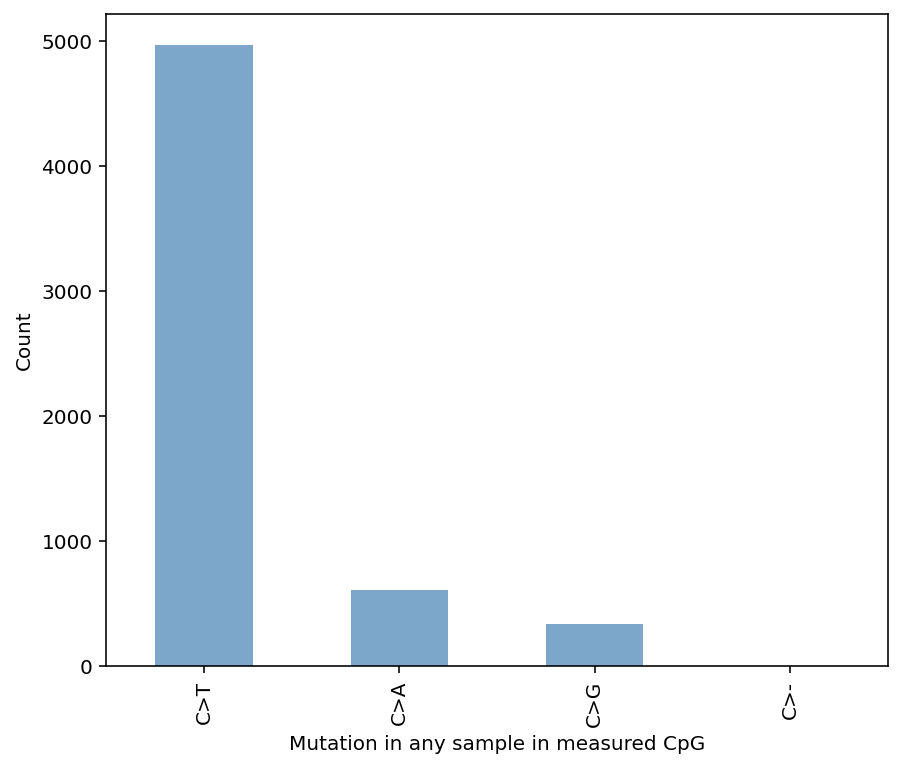

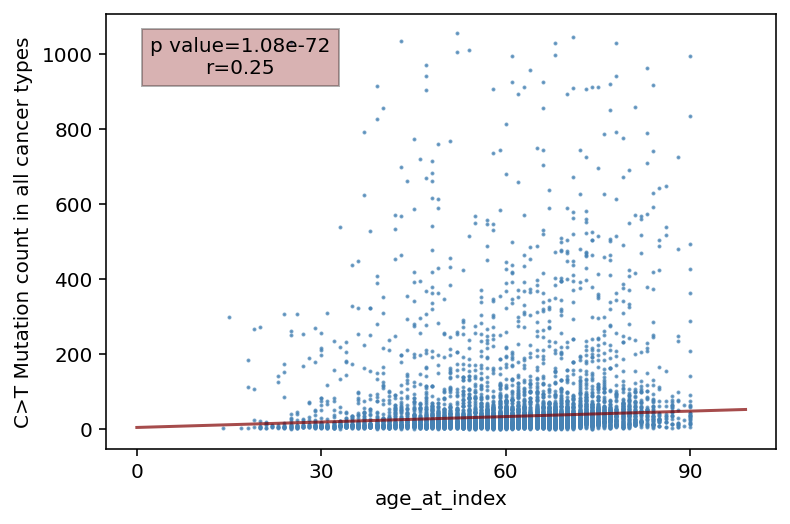

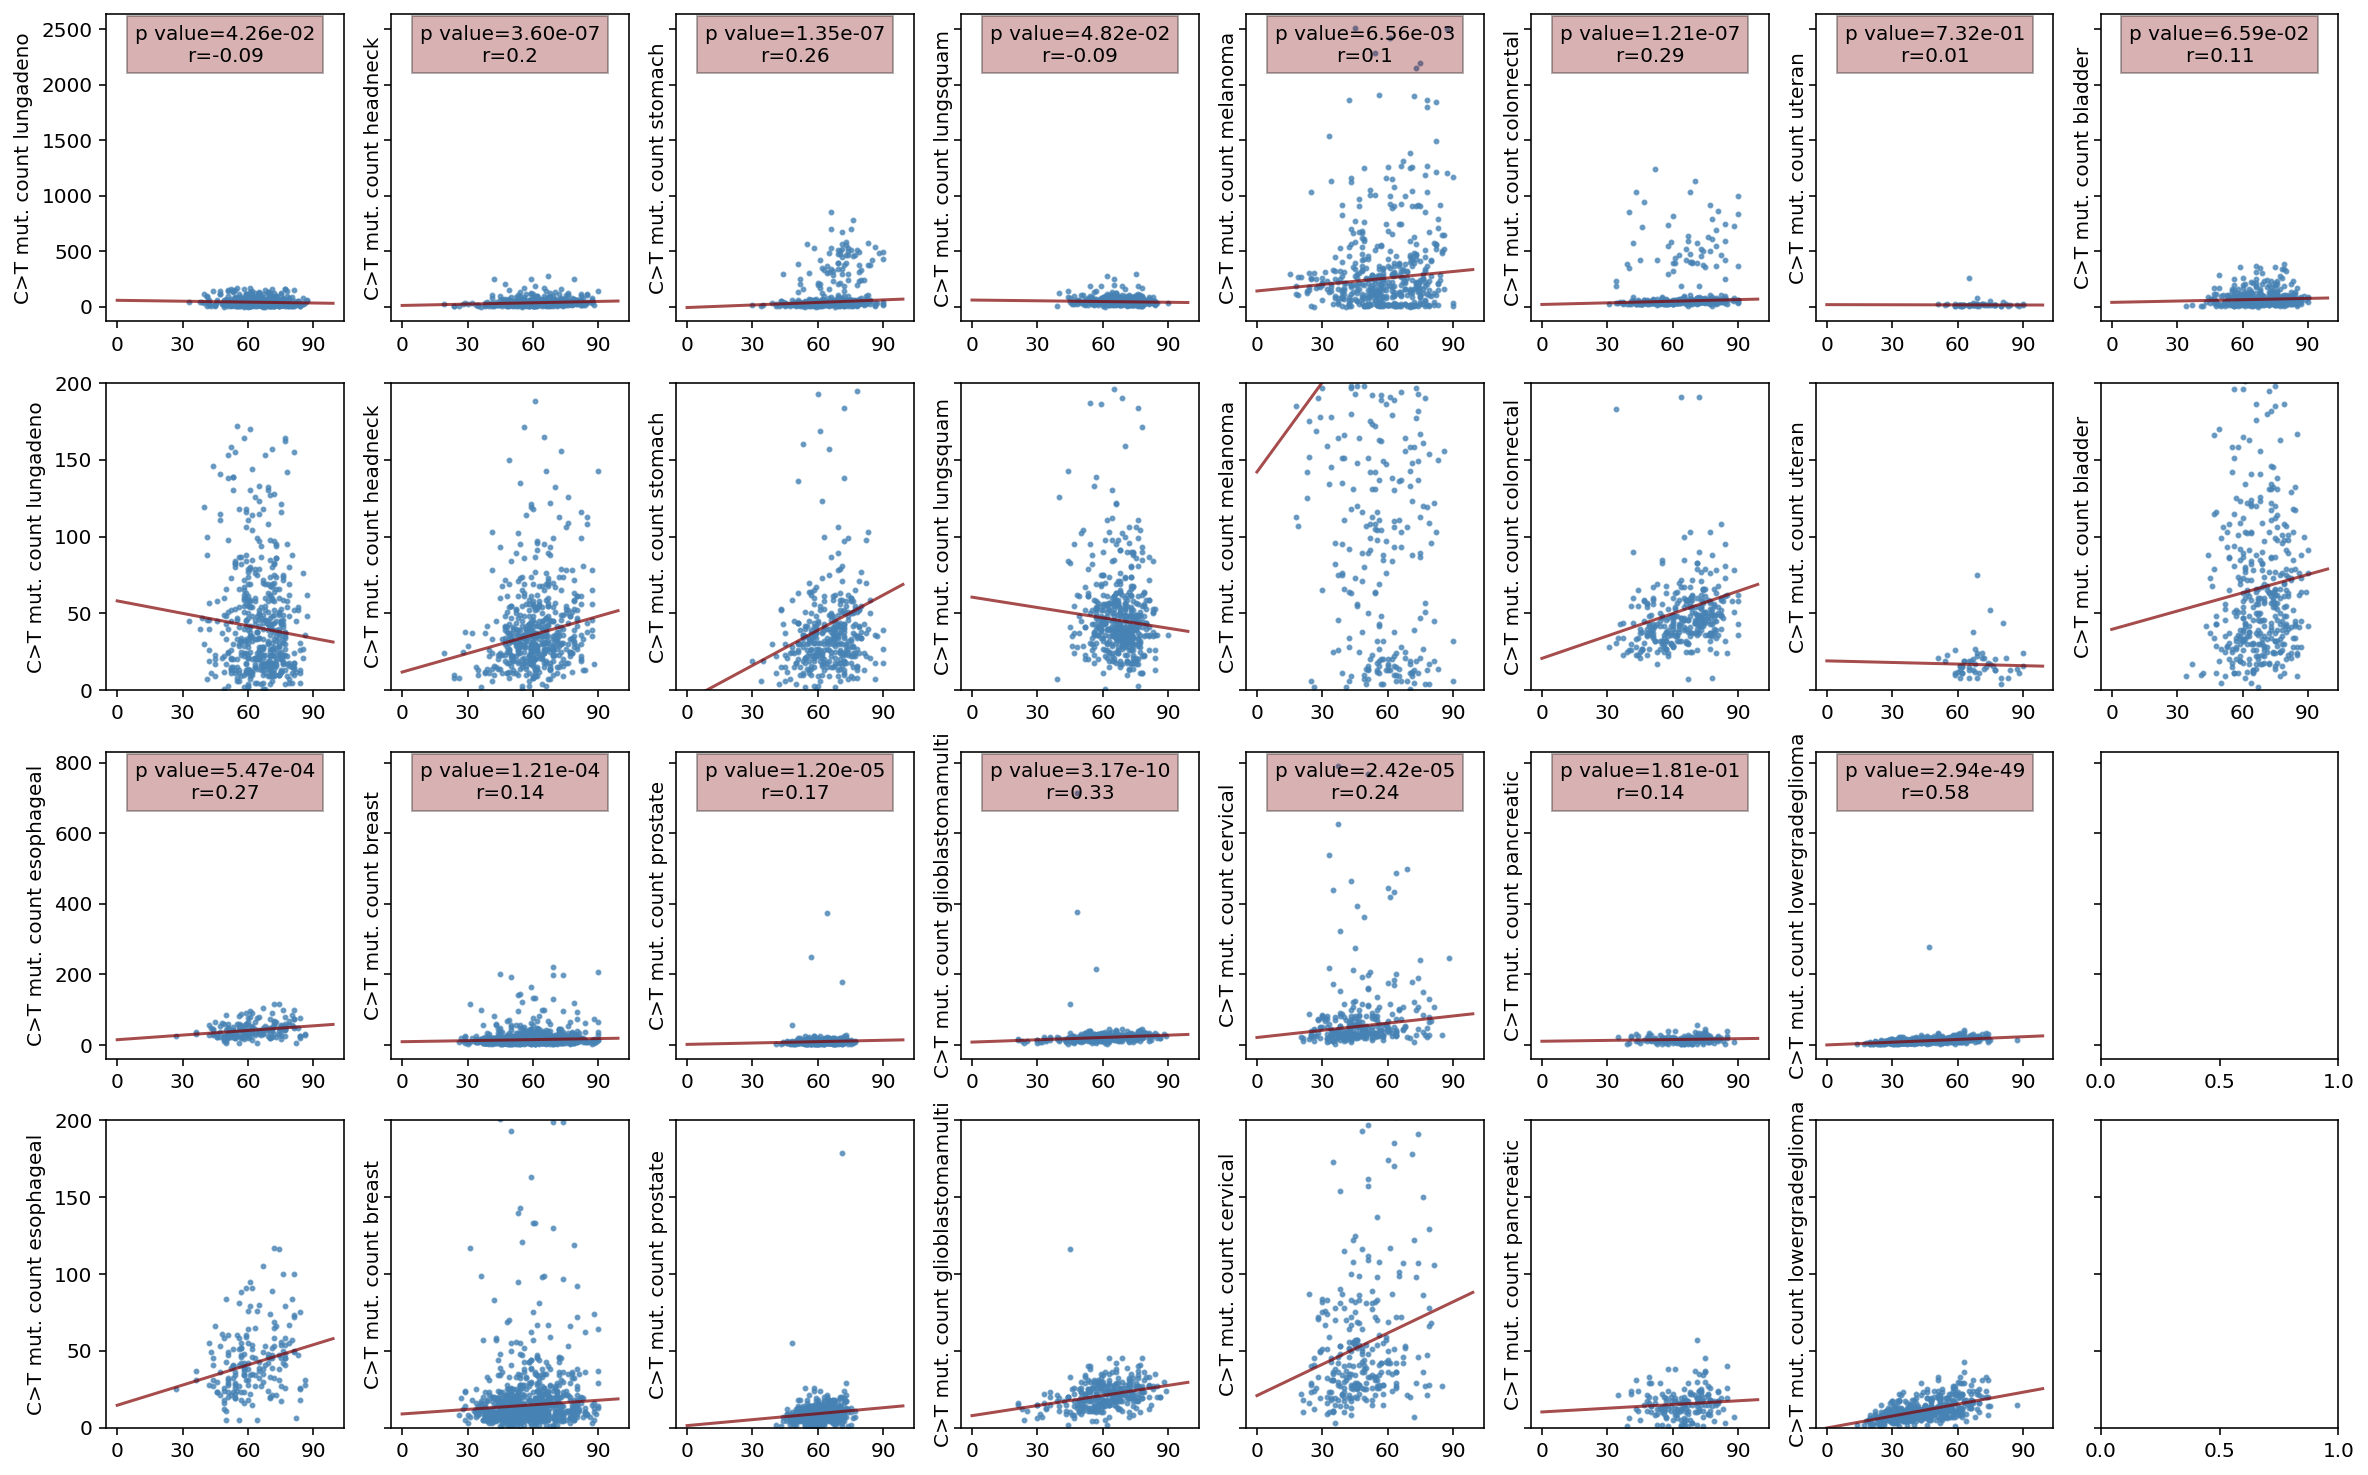

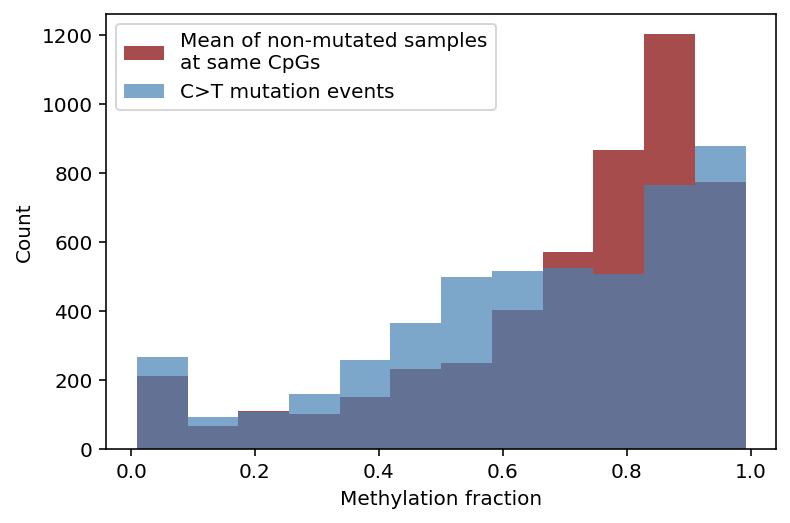

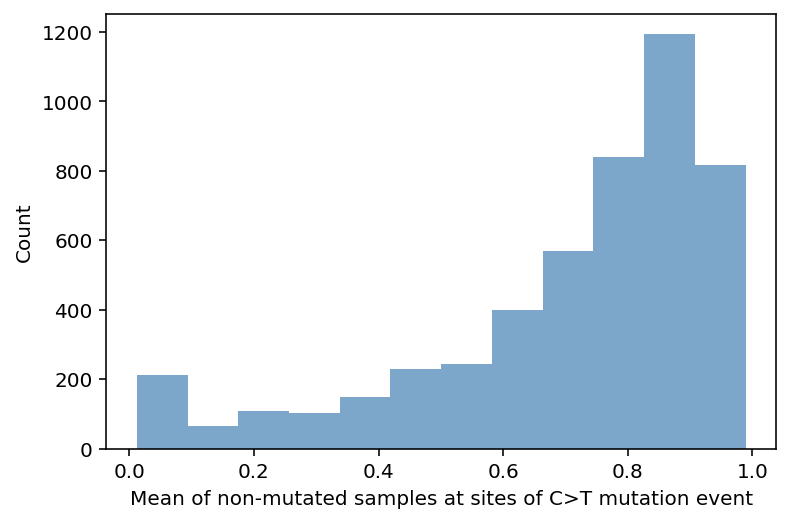

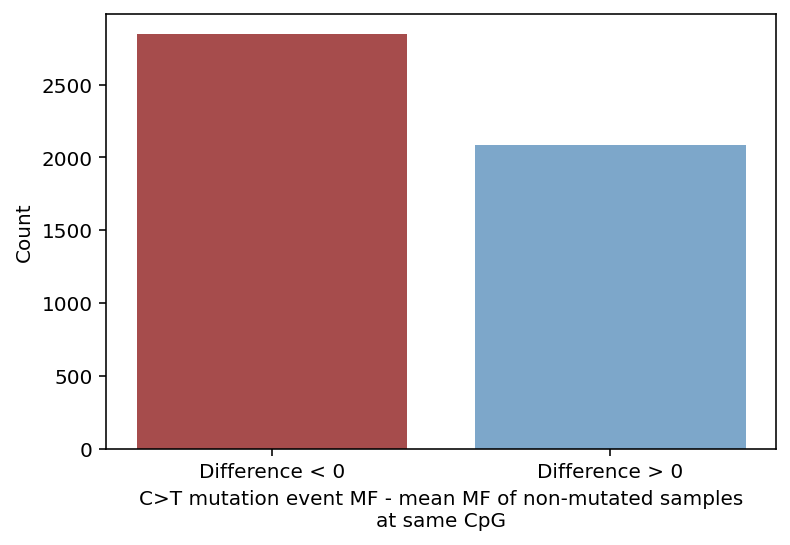

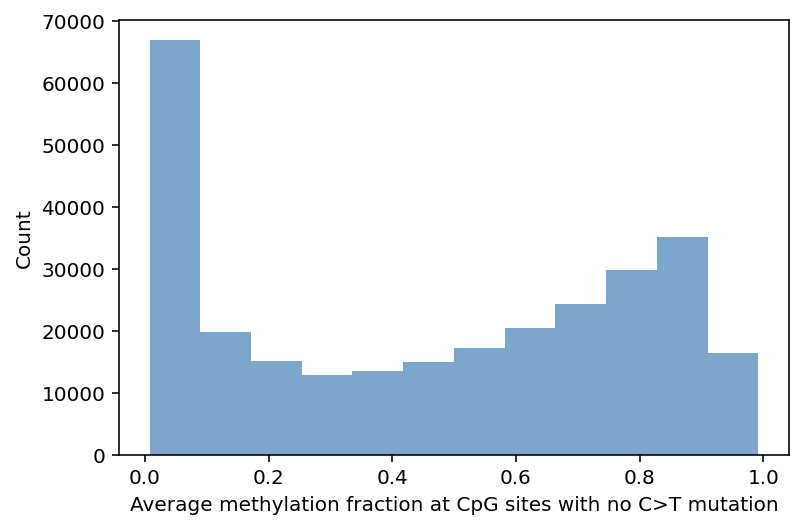

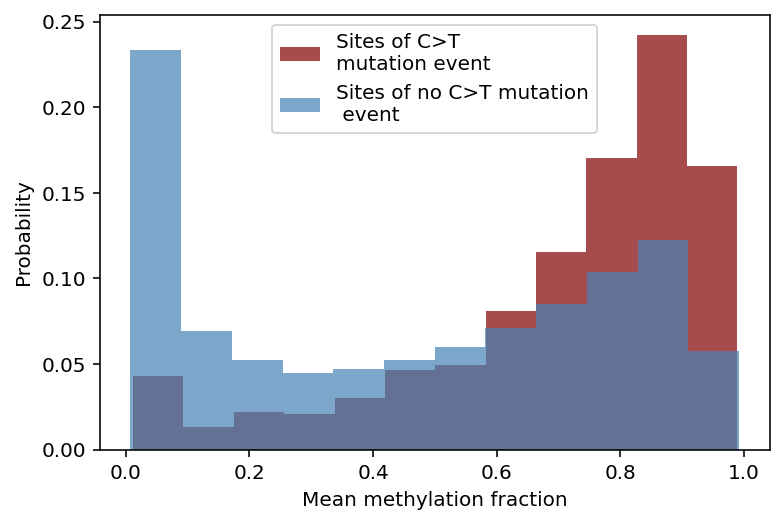

In [6]:
mut_in_measured_cpg_df, ct_mut_in_measured_cpg_df, ct_mut_in_measured_cpg_w_methyl_df = analysis.main(illumina_cpg_locs_df, out_dir, all_mut_df, all_methyl_df_t, all_meta_df, dataset_names_list) 

In [7]:
# save ct_mut_in_measured_cpg_w_methyl_df
ct_mut_in_measured_cpg_w_methyl_df.to_parquet(os.path.join(out_dir, "ct_mut_in_measured_cpg_w_methyl_df.parquet"))

## Do comethylation analysis

### comethylation without absolute value

In [46]:
corr_fns = sorted(glob.glob( "/cellar/users/zkoch/methyl_mut_proj/corr_matrices/chr_1*.parquet"))

corr_df = comethylation.read_correlations(corr_fns, illumina_cpg_locs_df)

ct_mut_in_measured_cpg_w_methyl_age_df, all_methyl_age_df_t = comethylation.add_ages_to_methylation(ct_mut_in_measured_cpg_w_methyl_df, all_meta_df, all_methyl_df_t)

# get num_mut_sites sites with largeset MF differences that are on chrom 1
num_mut_sites = 100
most_negative_diffs = ct_mut_in_measured_cpg_w_methyl_age_df[ct_mut_in_measured_cpg_w_methyl_age_df['#id'].isin(corr_df.columns)].sort_values(by='difference').iloc[:num_mut_sites]
max_diff_corr_df = corr_df[most_negative_diffs['#id']]

In [63]:
result_dfs = []

In [64]:
# calculate mutation impact varying percentile of linked CpG sites
result_dfs = comethylation.mutation_eff_varying_linkage(ct_mut_in_measured_cpg_w_methyl_age_df, max_diff_corr_df, all_methyl_age_df_t,illumina_cpg_locs_df, num_linked_sites = 100, age_bin_size = 10)

0.99
0.8811111111111111
0.7722222222222221
0.6633333333333333
0.5544444444444444
0.44555555555555554
0.33666666666666667
0.22777777777777777
0.11888888888888888
0.01


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


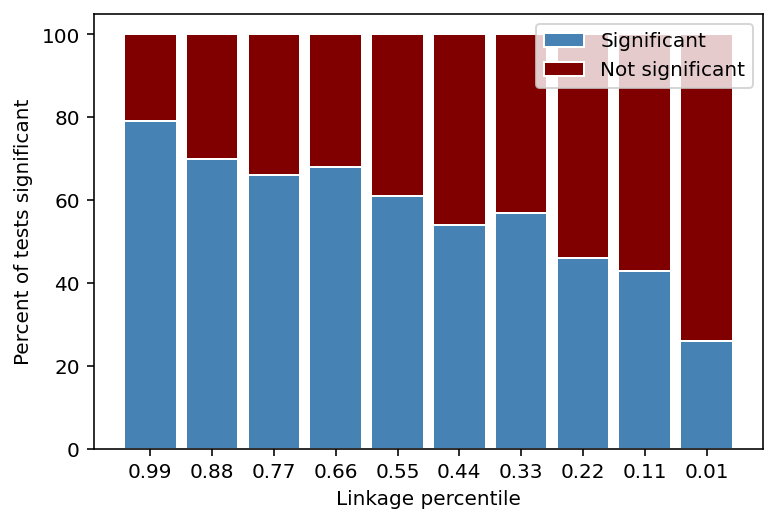

In [65]:
# updated to be MavgErr
comethylation.plot_sig_bars(result_dfs)

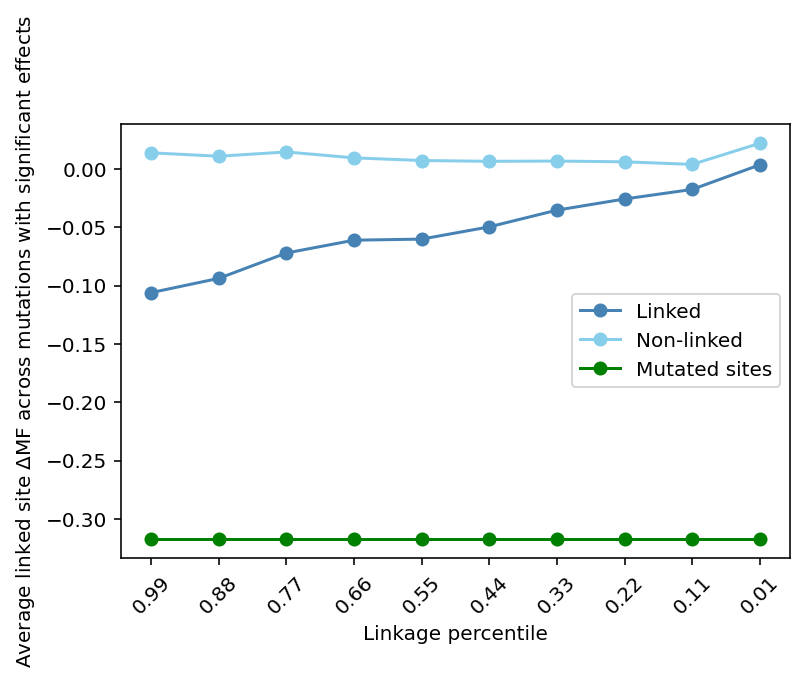

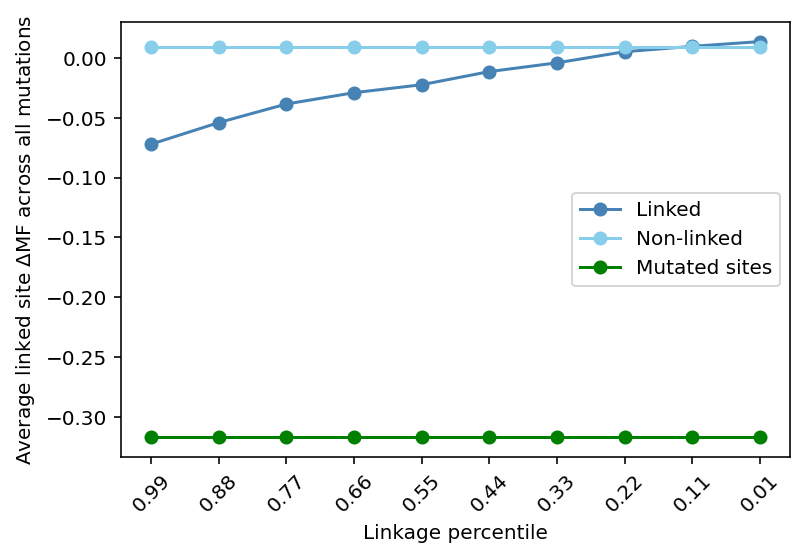

In [86]:
comethylation.plot_eff_line(result_dfs, ct_mut_in_measured_cpg_w_methyl_age_df, max_diff_corr_df, sig_only=True)
comethylation.plot_eff_line(result_dfs, ct_mut_in_measured_cpg_w_methyl_age_df, max_diff_corr_df, sig_only=False)


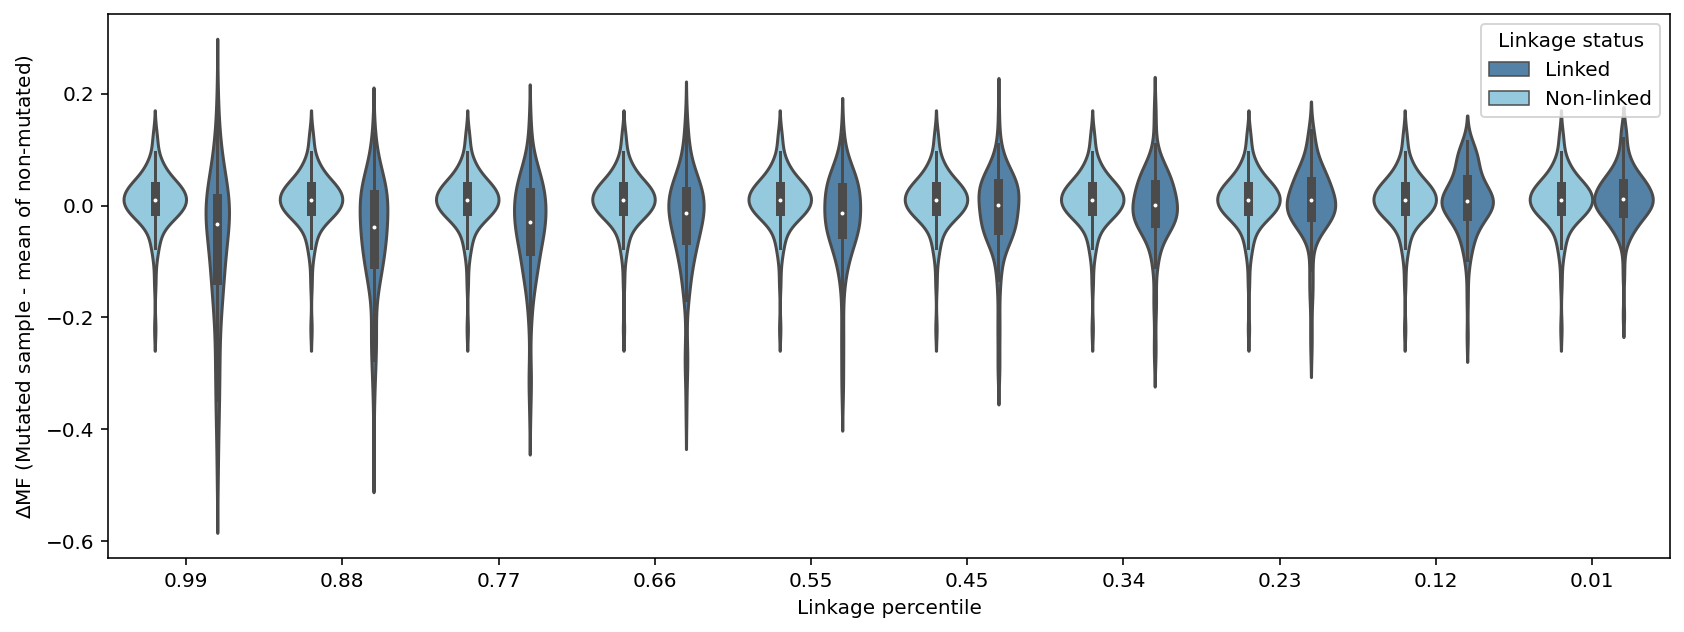

In [89]:
comethylation.plot_eff_violin(result_dfs)

## EWAS chr1

In [99]:
illum_cpg_locs_fn = "/cellar/users/zkoch/methyl_mut_proj/data/illumina_cpg_450k_locations.csv"
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_072422"
data_dirs = glob.glob( os.path.join("/cellar/users/zkoch/methyl_mut_proj/data", "tcga*data"))


#illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, run_name, dataset_names_list = get_data.main(illum_cpg_locs_fn, out_dir, data_dirs)
# only keep sites on chr 1
chr_methyl_df = all_methyl_df.loc[all_methyl_df.index.isin(illumina_cpg_locs_df[illumina_cpg_locs_df.chr == "1"]['#id'].to_list())]
# only keep ages that match to columns of chr_methyl_df
all_meta_df = all_meta_df.loc[all_meta_df.index.isin(chr_methyl_df.columns)]
# only keep columns that have ages
chr_methyl_df = chr_methyl_df[chr_methyl_df.columns[chr_methyl_df.columns.isin(all_meta_df.index)]]
# put samples in same order as methylation
all_meta_df = all_meta_df.loc[chr_methyl_df.columns]


# do calculation
ewas_df = utils.EWAS(X = chr_methyl_df, y = all_meta_df['age_at_index'], out_fn = out_fn)
ewas_df.index = chr_methyl_df.index

In [109]:
ewas_df = pd.read_parquet(out_fn)

In [111]:
ewas_df.index = chr_methyl_df.index

In [112]:
ewas_df = ewas_df.sort_values(by = 'pearson_corrs')

In [224]:
all_methyl_df.columns

Index(['TCGA-44-4112', 'TCGA-NJ-A4YP', 'TCGA-86-8278', 'TCGA-62-A470',
       'TCGA-44-6778', 'TCGA-49-AARQ', 'TCGA-97-A4M1', 'TCGA-55-6975',
       'TCGA-99-8033', 'TCGA-78-7149',
       ...
       'TCGA-TM-A84G', 'TCGA-E1-A7Z6', 'TCGA-TM-A84I', 'TCGA-CS-5394',
       'TCGA-HT-A617', 'TCGA-DU-A76O', 'TCGA-DU-A5TW', 'TCGA-HT-7857',
       'TCGA-WY-A85A', 'TCGA-FG-5962'],
      dtype='object', length=5718)

In [214]:
# count nearby mutations in a sample for a given cpg
def count_nearby_muts(cpg_name, all_mut_df, illumina_cpg_locs_df):
    """
    @ cpg_name: cpg for which to look for nearby mutants
    @ sample_name: sample to look for mutants in
    @ returns: the number of nearby C>T mutations 
    """
    # get location of CpG from illumina
    cpg_chr = illumina_cpg_locs_df[illumina_cpg_locs_df['#id'] == cpg_name]['chr'].values[0]
    cpg_start = illumina_cpg_locs_df[illumina_cpg_locs_df['#id'] == cpg_name]['start'].values[0]
    nearby_df = all_mut_df[(all_mut_df['chr'] == cpg_chr) & (np.abs(all_mut_df['start'] - cpg_start) < 100000) & (all_mut_df['mutation'] == 'C>T')]
    return nearby_df

In [217]:
all_mut_df = all_mut_df[all_mut_df['sample'].isin(all_methyl_df.columns.to_list())]

In [218]:
# for each of the top 100 CpGs
cpg_sample_mut_count_df = pd.DataFrame(0, index=all_methyl_df.columns, columns=ewas_df.iloc[:1000].index)
for cpg_name, _ in ewas_df.iloc[:1000].iterrows():
    # find nearby muts across all samples
    nearby_df = count_nearby_muts(cpg_name, all_mut_df, illumina_cpg_locs_df)
    # increment count for each sample in result
    nearby_sample_counts = nearby_df['sample'].value_counts()
    for sample_name, count in nearby_sample_counts.items():
        cpg_sample_mut_count_df.loc[sample_name, cpg_name] += count

In [240]:
cpg_sample_mut_count_df.to_parquet(os.path.join(out_dir, "cpg_sample_mut_count_negative_1000.parquet"))

In [236]:
these_sample_cpgs_methyls = all_methyl_df.loc[ewas_df.iloc[:1000].index,:]

In [242]:
# these_sample_cpgs_methyls is MFs of 1000 cpgs sites X all samples 
# ewas_df.iloc[:1000] is correlations of 1000 cpg sites with age
# cpg_sample_mut_count_df is counts of mutations within 100kb for all samples x 1000 CpG sites

#### corr(age, # linked mutations in site i)

In [249]:
cpg_sample_mut_count_to_corr = cpg_sample_mut_count_df.loc[cpg_sample_mut_count_df.index.isin(all_meta_df.index)]
ages_to_corr = all_meta_df.loc[cpg_sample_mut_count_to_corr.index]['age_at_index']

In [252]:
age_mut_count_corr = cpg_sample_mut_count_to_corr.corrwith(ages_to_corr)

<AxesSubplot:>

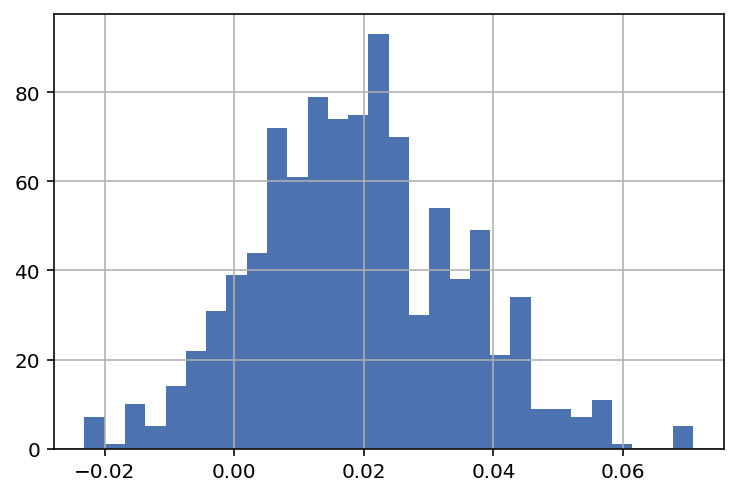

In [255]:
age_mut_count_corr.hist(bins=30)

#### corr(change in MF from population mean, # linked mutations in site i)

In [257]:
ct_mut_in_measured_cpg_w_methyl_df

,sample,chr,start,end,reference,alt,DNA_VAF,mutation,dataset,#id,Strand,methyl_fraction,avg_methyl_frac,difference
4,TCGA-05-4390,18,48256146,48256146,C,T,0.60,C>T,lungadeno,cg00019841,F,0.8468,0.868757,-0.021957
11,TCGA-05-4410,12,4919230,4919230,C,T,0.17,C>T,lungadeno,cg10671668,R,0.4677,0.352728,0.114972
12,TCGA-05-4410,1,152538380,152538380,C,T,0.30,C>T,lungadeno,cg23724738,R,0.5204,0.522841,-0.002441
15,TCGA-05-4410,7,119915076,119915076,C,T,0.10,C>T,lungadeno,cg19150007,R,0.9772,0.972346,0.004854
16,TCGA-05-4415,16,67698948,67698948,C,T,0.24,C>T,lungadeno,cg03169170,R,0.8379,0.866360,-0.028460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7439,TCGA-TM-A84B,16,69971126,69971126,C,T,0.50,C>T,lowergradeglioma,cg01656717,R,0.9344,0.921667,0.012733
7440,TCGA-TM-A84J,2,65299194,65299194,C,T,0.21,C>T,lowergradeglioma,cg14182758,F,0.5069,0.793095,-0.286195
7443,TCGA-VM-A8C8,11,61110297,61110297,C,T,0.25,C>T,lowergradeglioma,cg17304467,R,0.8579,0.753369,0.104531
7444,TCGA-VM-A8C8,15,50557873,50557873,C,T,0.21,C>T,lowergradeglioma,cg02587120,R,0.8406,0.757195,0.083405
